# Import dependencies

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import missingno as ms
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score


from sklearn.neural_network import MLPClassifier
import pickle

# Data Loading

In [ ]:
df = pd.read_csv('df_out.csv')

In [ ]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,NaN,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


In [ ]:
df.shape

(10000, 20)

# Data Preparation

## Data cleaning

### Missing values

In [ ]:
df_clean = df.copy()

In [ ]:
info = df.info()
info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

<Axes: >

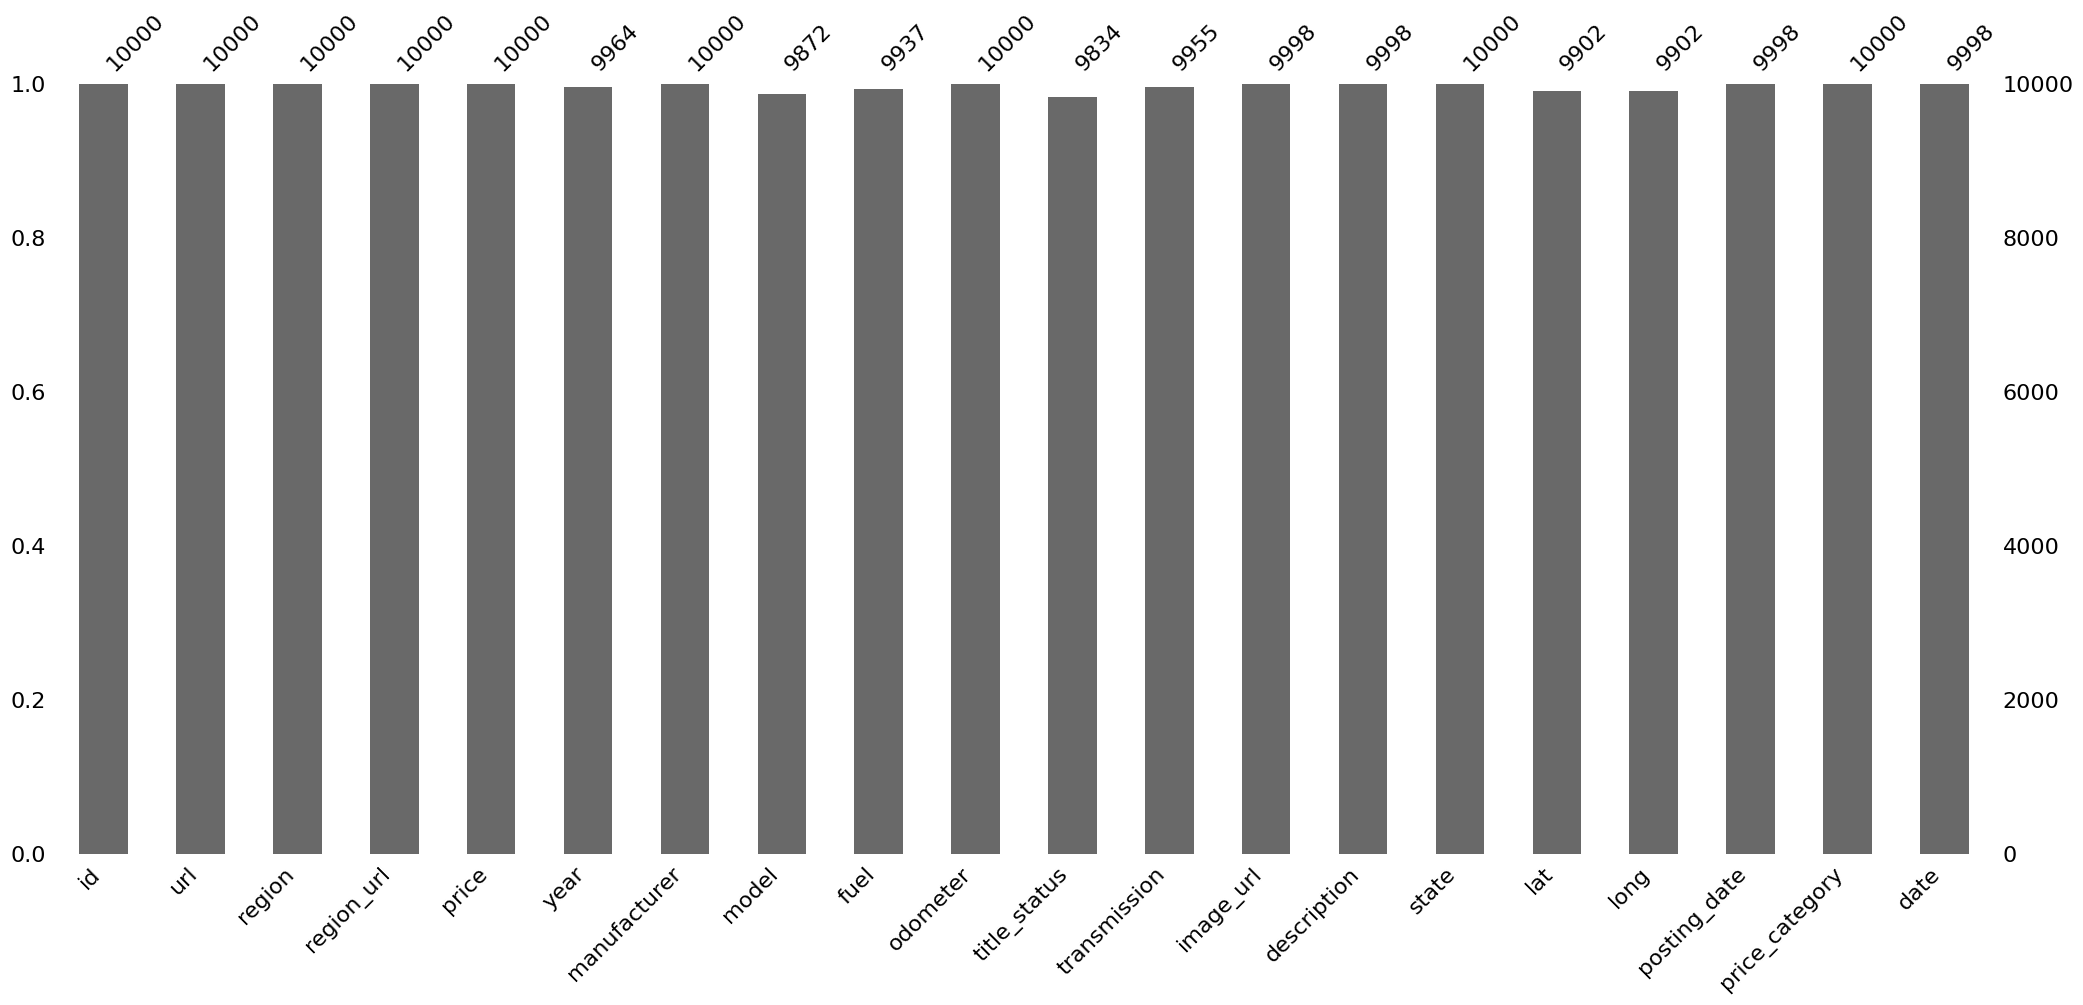

In [ ]:
ms.bar(df)

<Axes: >

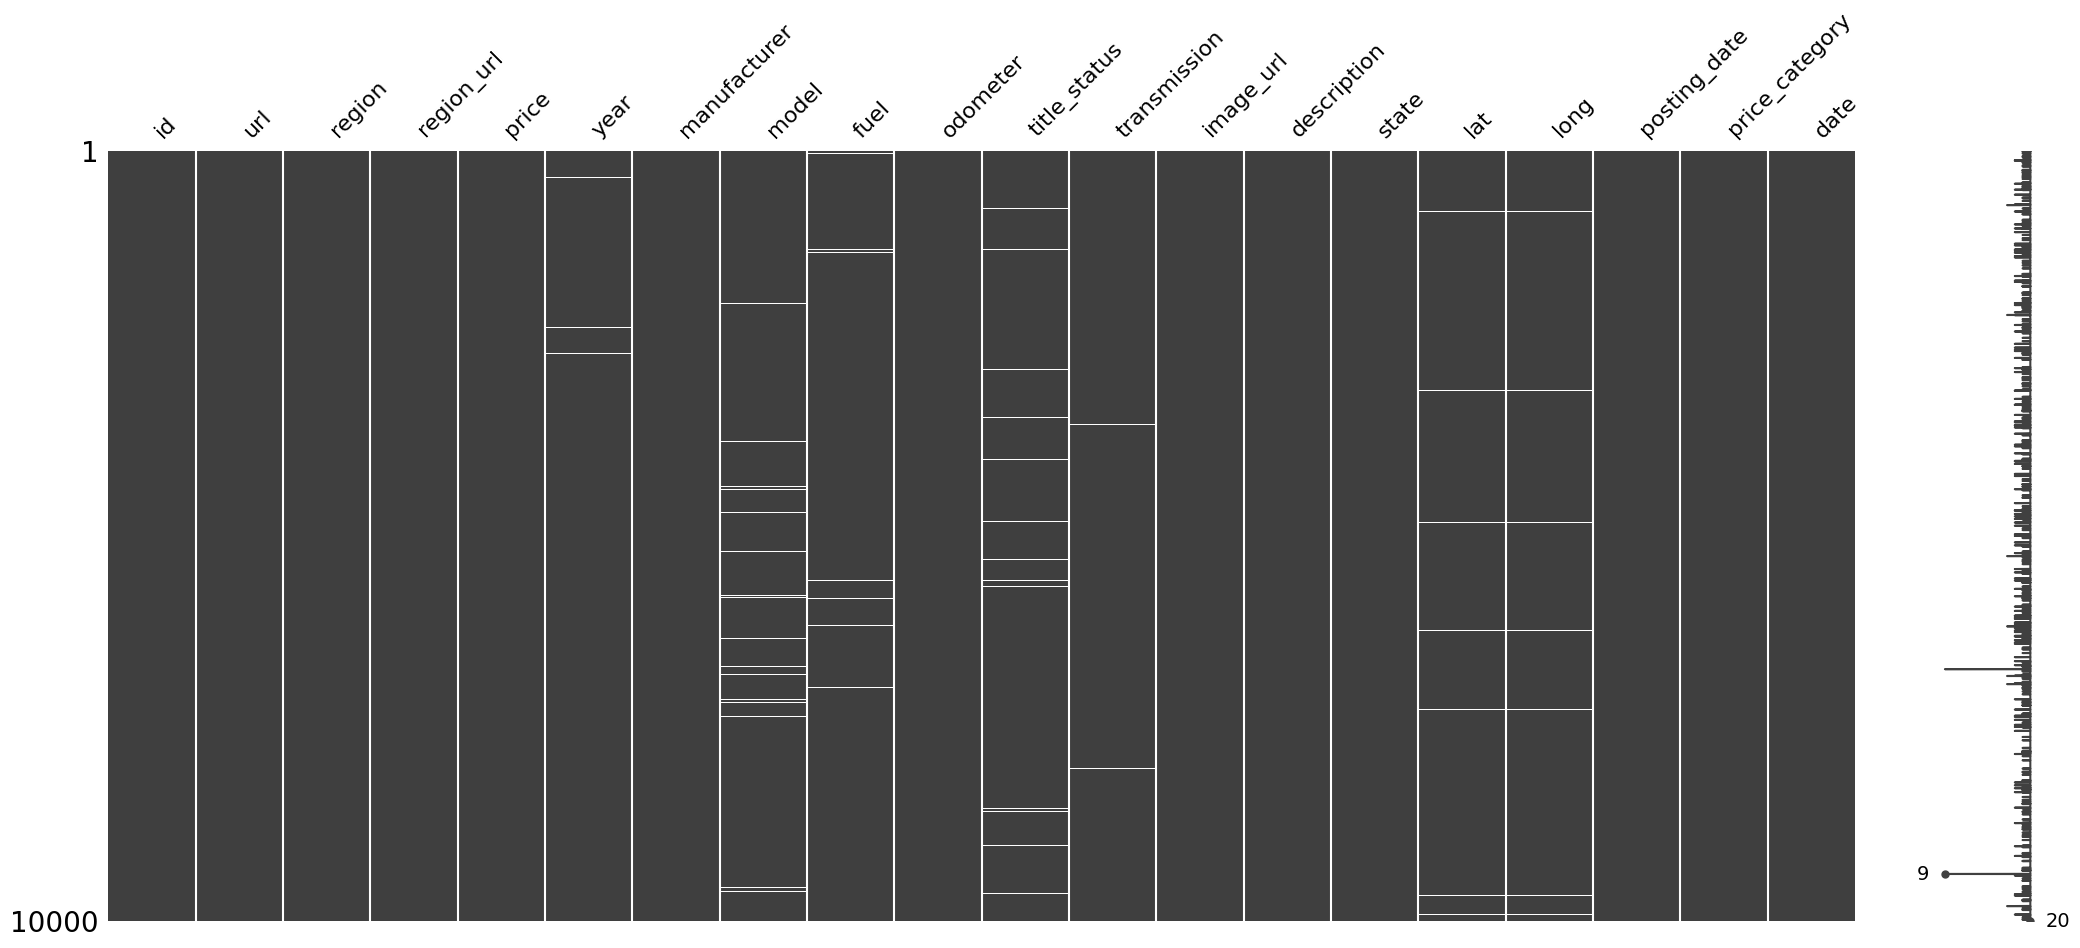

In [ ]:
ms.matrix(df)

Больше всего пропущенных значений в признаках "модель" и "статус". Сама по себе модель вряд ли окажет заметное влияние на предсказательную способность модели, поэтому заменим пропущенные значения на "other". Статус, в свою очередь, может иметь большее влияние, но определить его самостоятельно возможности нет, так что тоже заменим на "other". Так же поступим с пропусками в "description" и в "image_url".

Пропущенные значения в поле year заменим на медианное значение по признаку, чтобы избежать влияния возможных выбросов.
Fuel и transmission - категориальные признак, и пропущенные значения стоит заменить на их моды. Аналогично поступим с пропусками в date и posting_date.

Отсутствующие значения в lat и long заменим средним значением этих параметров. 

In [ ]:
def rep_w_median(feature):
    md = df_clean[feature].median()
    df_clean[feature] = df_clean[feature].fillna(md)

In [ ]:
rep_w_median('year')
df_clean.year.isna().sum()

0

In [ ]:
def rep_w_other(feature):
    df_clean[feature] = df_clean[feature].fillna('other')

In [ ]:
rep_w_other(['model', 'title_status', 'description', 'image_url'])
df_clean[['model', 'title_status', 'description', 'image_url']].isna().sum()

model           0
title_status    0
description     0
image_url       0
dtype: int64

In [ ]:
def rep_w_mode(feature):
    for f in feature:
        mode = df_clean[f].value_counts().index[0]
        df_clean[f] = df_clean[f].fillna(mode)

In [ ]:
rep_w_mode(['fuel', 'transmission', 'date', 'posting_date'])
df_clean[['fuel', 'transmission', 'date', 'posting_date']].isna().sum()

fuel            0
transmission    0
date            0
posting_date    0
dtype: int64

In [ ]:
def rep_w_mean(feature):
     for f in feature:
        mean = df_clean[f].mean()
        df_clean[f] = df_clean[f].fillna(mean)

In [ ]:
rep_w_mode(['lat', 'long'])
df_clean[['lat', 'long']].isna().sum()

lat     0
long    0
dtype: int64

In [ ]:
df_clean.isna().sum()

id                0
url               0
region            0
region_url        0
price             0
year              0
manufacturer      0
model             0
fuel              0
odometer          0
title_status      0
transmission      0
image_url         0
description       0
state             0
lat               0
long              0
posting_date      0
price_category    0
date              0
dtype: int64

### Outliners

In [ ]:
def calculcate_outliners(feature):
    q25 = df_clean[feature].quantile(0.25)
    q75 = df_clean[feature].quantile(0.75)
    iqr = q75 - q25
    bounds = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return bounds

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   url             10000 non-null  object 
 2   region          10000 non-null  object 
 3   region_url      10000 non-null  object 
 4   price           10000 non-null  int64  
 5   year            9964 non-null   float64
 6   manufacturer    10000 non-null  object 
 7   model           9872 non-null   object 
 8   fuel            9937 non-null   object 
 9   odometer        10000 non-null  int64  
 10  title_status    9834 non-null   object 
 11  transmission    9955 non-null   object 
 12  image_url       9998 non-null   object 
 13  description     9998 non-null   object 
 14  state           10000 non-null  object 
 15  lat             9902 non-null   float64
 16  long            9902 non-null   float64
 17  posting_date    9998 non-null   

Признаки, в которых могут наблюдаться выбросы: year, odometr, lat и long, так как это численные признаки.

In [ ]:
def draw_hist(feature):
    plt.figure(figsize=(25, 15))
    plt.hist(df[feature], bins=100)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

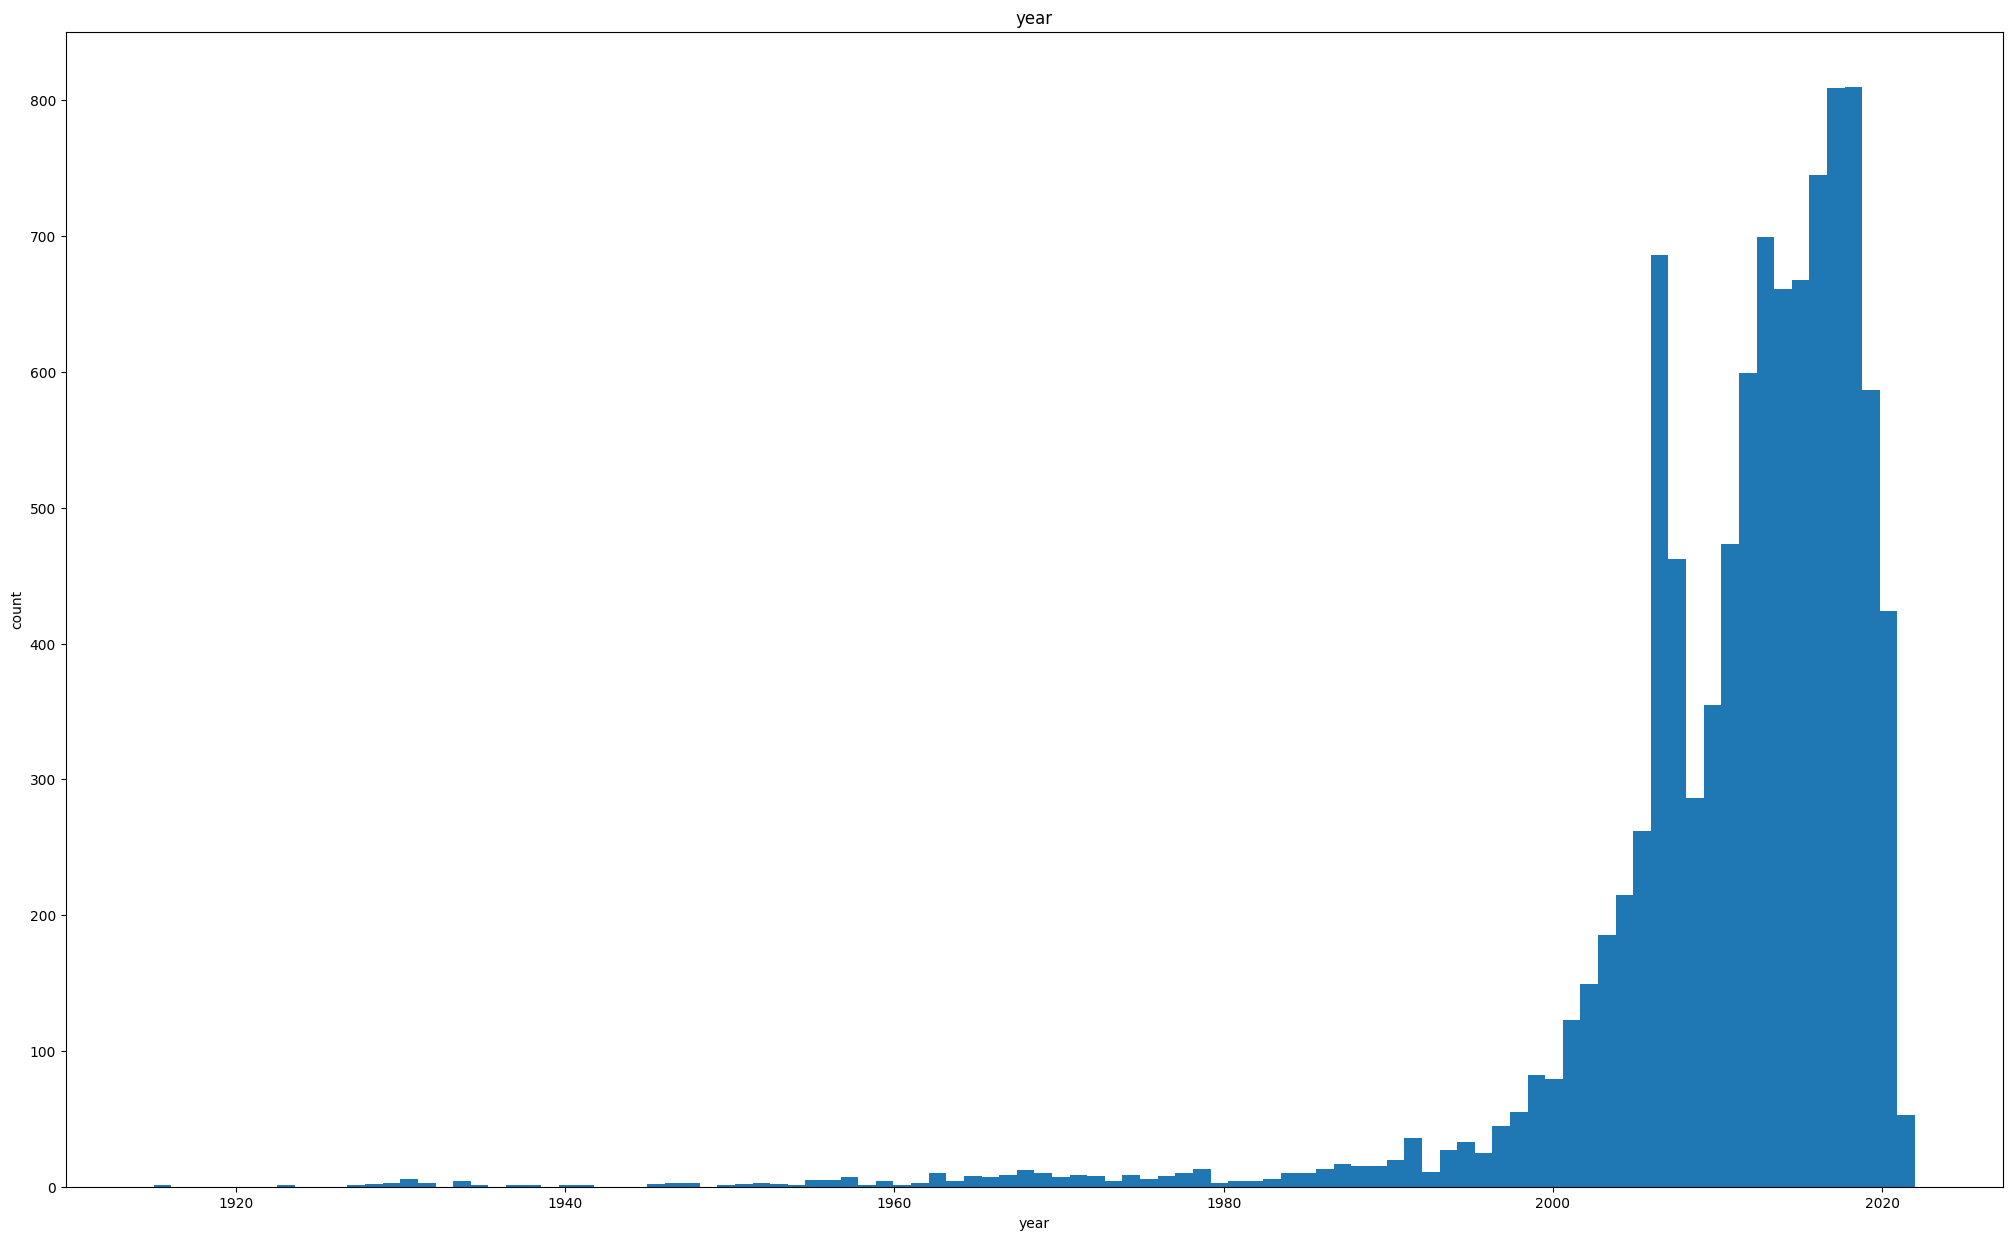

In [ ]:
draw_hist('year')

Посчитаем границы выбросов для года выпуска с помощью интерквартильного размаха

In [ ]:
year_bonds = calculcate_outliners('year')
year_bonds

(1994.5, 2030.5)

На первый взгляд, всё, что старше 1994 года-выброс. Однако, не стоит исключать раритетные или коллекционные модели. Лучше посмотреть на данные, которые кажутся выбросами. 

In [ ]:
year_outliners = df_clean[df_clean['year'] < year_bonds[0]]
year_outliners.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994.0,ford,e-series van universal by glaval designer luxu...,gas,156925,clean,automatic,https://images.craigslist.org/00r0r_13JUlXZOMl...,"Priced to Sell: $14,9951994 Ford E-Series Van ...",wa,45.391373,-122.613533,2021-05-04T20:22:11-0700,medium,2021-05-05 03:22:11+00:00
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970.0,other,oldsmobile 442,gas,111111,clean,automatic,https://images.craigslist.org/00S0S_agk7Nol4CO...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25T10:10:43-0500,high,2021-04-25 15:10:43+00:00
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948.0,ford,coe,gas,1,clean,automatic,https://images.craigslist.org/00M0M_8jgBCZZuG6...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29T10:49:29-0700,high,2021-04-29 17:49:29+00:00
66,7310077530,https://hudsonvalley.craigslist.org/cto/d/bloo...,hudson valley,https://hudsonvalley.craigslist.org,5500,1990.0,other,Diahatsu,gas,30000,clean,manual,https://images.craigslist.org/00T0T_a4VRbx40ea...,1991 Daihatsu hijet 5 speed extended cab....im...,ny,41.564400,-74.430400,2021-04-20T18:30:18-0400,low,2021-04-20 22:30:18+00:00
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968.0,chevrolet,camaro,gas,43320,clean,manual,https://images.craigslist.org/00h0h_2N66LMJBAI...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29T15:11:01-0600,high,2021-04-29 21:11:01+00:00


In [ ]:
year_outliners['price_category'].value_counts()

low       181
medium    135
high       78
Name: price_category, dtype: int64

In [ ]:
year_outliners.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
13,7317089086,https://seattle.craigslist.org/see/ctd/d/portl...,seattle-tacoma,https://seattle.craigslist.org,14995,1994.0,ford,e-series van universal by glaval designer luxu...,gas,156925,clean,automatic,https://images.craigslist.org/00r0r_13JUlXZOMl...,"Priced to Sell: $14,9951994 Ford E-Series Van ...",wa,45.391373,-122.613533,2021-05-04T20:22:11-0700,medium,2021-05-05 03:22:11+00:00
21,7312327909,https://madison.craigslist.org/cto/d/madison-1...,madison,https://madison.craigslist.org,89995,1970.0,other,oldsmobile 442,gas,111111,clean,automatic,https://images.craigslist.org/00S0S_agk7Nol4CO...,1970 Oldsmobile 442 Convertible 442 Indy Pace ...,wi,43.098400,-89.273400,2021-04-25T10:10:43-0500,high,2021-04-25 15:10:43+00:00
57,7314413105,https://inlandempire.craigslist.org/ctd/d/cost...,inland empire,https://inlandempire.craigslist.org,69888,1948.0,ford,coe,gas,1,clean,automatic,https://images.craigslist.org/00M0M_8jgBCZZuG6...,Awesome Resto-Mod COE Ford Car Hauler. Equippe...,ca,33.680100,-117.908500,2021-04-29T10:49:29-0700,high,2021-04-29 17:49:29+00:00
66,7310077530,https://hudsonvalley.craigslist.org/cto/d/bloo...,hudson valley,https://hudsonvalley.craigslist.org,5500,1990.0,other,Diahatsu,gas,30000,clean,manual,https://images.craigslist.org/00T0T_a4VRbx40ea...,1991 Daihatsu hijet 5 speed extended cab....im...,ny,41.564400,-74.430400,2021-04-20T18:30:18-0400,low,2021-04-20 22:30:18+00:00
106,7314527175,https://rapidcity.craigslist.org/ctd/d/sherman...,rapid city / west SD,https://rapidcity.craigslist.org,43500,1968.0,chevrolet,camaro,gas,43320,clean,manual,https://images.craigslist.org/00h0h_2N66LMJBAI...,1968 Chevrolet Camaro Convertible. VIN:124678N...,sd,33.637200,-96.618400,2021-04-29T15:11:01-0600,high,2021-04-29 21:11:01+00:00


In [ ]:
year_outliners[year_outliners['price_category'] == 'high'].odometer.mean()

56677.39743589744

In [ ]:
year_outliners[year_outliners['price_category'] == 'medium'].odometer.mean()

65841.06666666667

In [ ]:
year_outliners[year_outliners['price_category'] == 'low'].odometer.mean()

98087.86740331491

Признак года выпуска действительно содержит аномалии. Однако, их нельзя назвать бессмысленными. В датасете содержатся как раритерные(дорогие) автомобили, так и просто старые(дешевые), не представляющие особо интереса. На данном этапе не будем никак преобразовывать эти аномалии, однако, это можно сделать позже, после оценки модели.

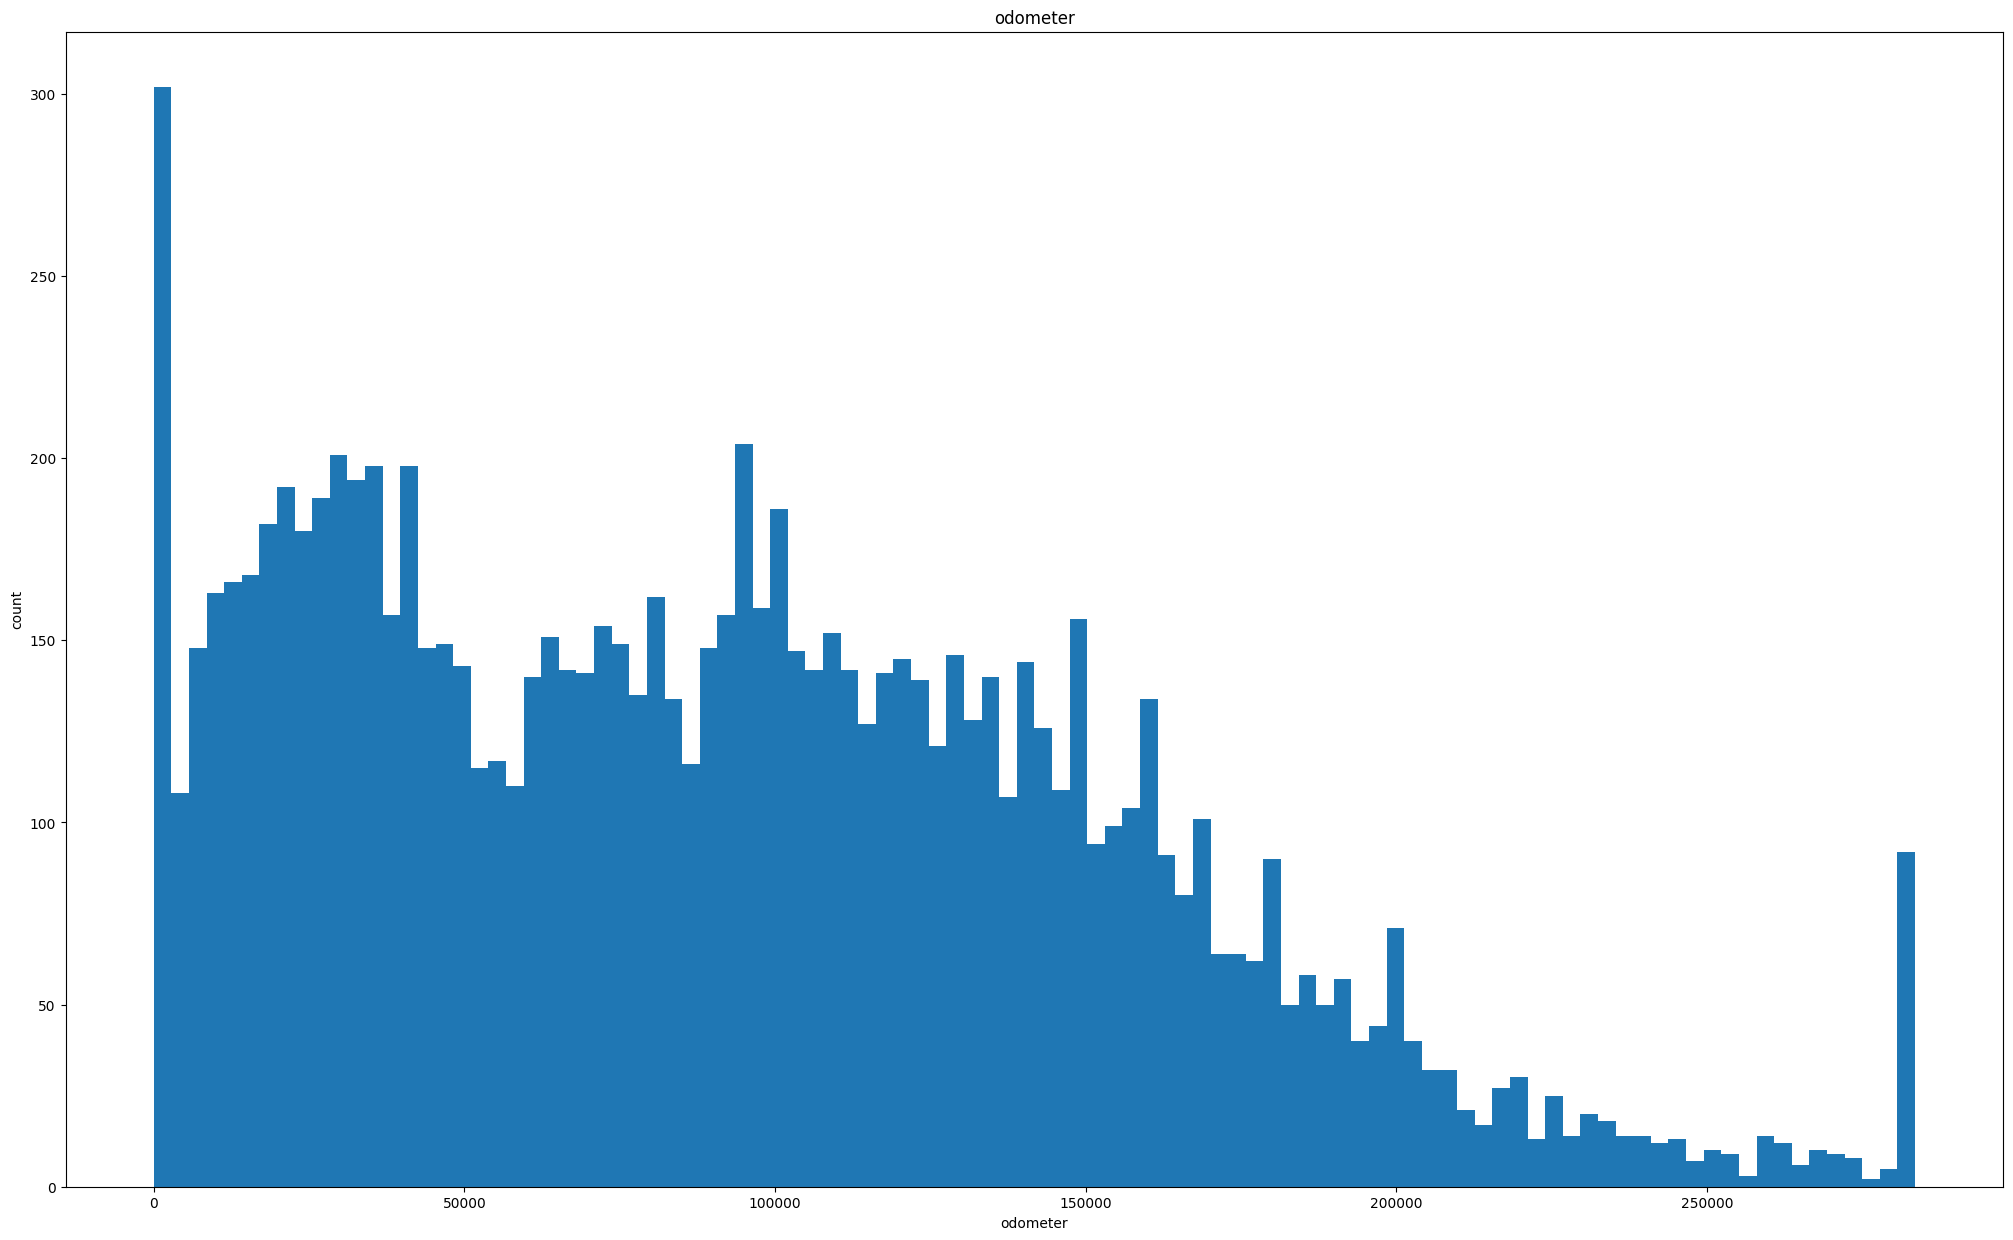

In [ ]:
draw_hist('odometer')

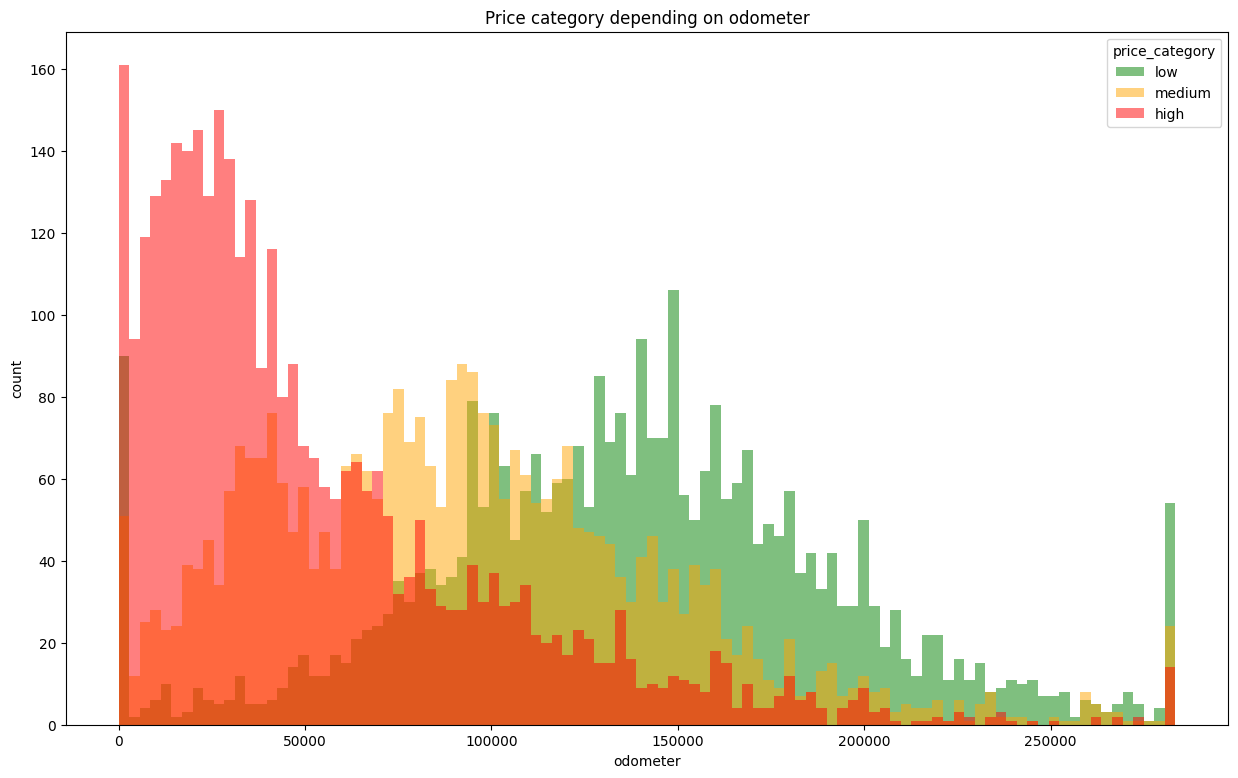

In [ ]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(15, 9))
for price_category in colors:
    color = colors[price_category]
    data = df_clean[df_clean['price_category'] == price_category]
    ax.hist(data['odometer'], bins = 100, color=color, alpha=0.5)
plt.xlabel('odometer')
plt.ylabel('count')
plt.title('Price category depending on odometer')
plt.legend(colors, title='price_category')
plt.show()

Полученный график описывает логичную закономерность - чем меньше пробег, тем больше цена. Так что не будем трогать значения этого признака, то есть считаем, что выбросов нет.

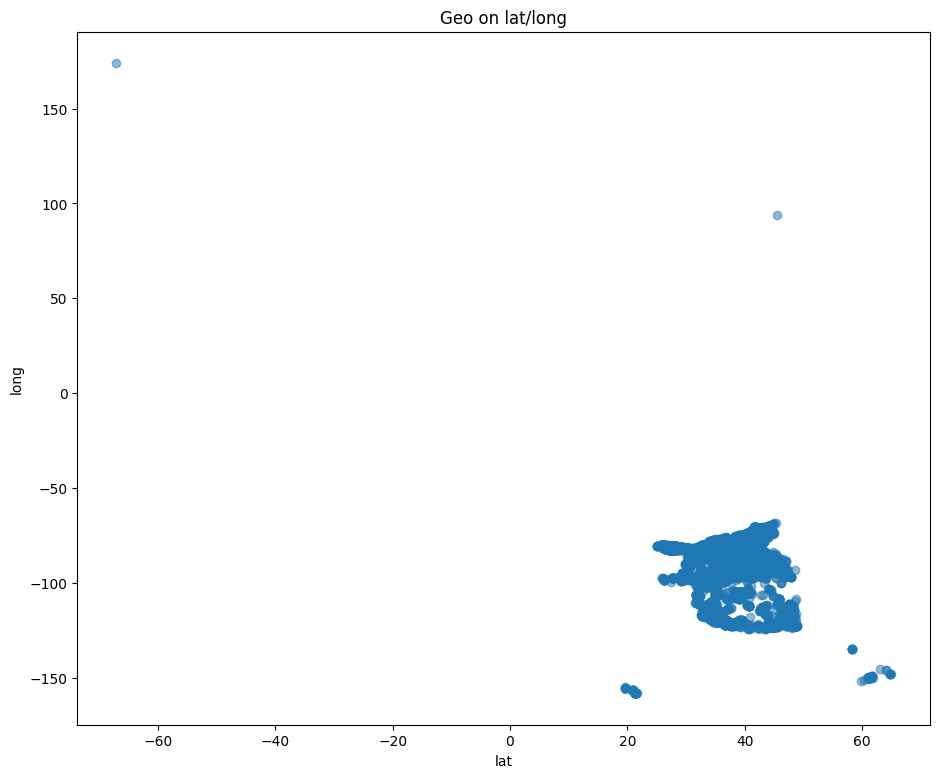

In [ ]:
plt.figure(figsize=(11, 9))
plt.scatter(df.lat, df.long, alpha=0.5)
plt.xlabel('lat')
plt.ylabel('long')
plt.title('Geo on lat/long')
plt.show()

In [ ]:
lat_bonds = calculcate_outliners('lat')
lat_bonds

(23.571021375000008, 53.83496437499999)

In [ ]:
long_bonds = calculcate_outliners('long')
long_bonds

(-149.89938224999997, -39.65738825000001)

На графике видны значения, сильно отдалённые от большинства. Можно предположить, что это объявления с Гавайев или с Аляски, но вряд ли это добавит точности нашей модели. Заменим выбросы граничными значениями.

In [ ]:
lat_outliners = (df_clean['lat'] < lat_bonds[0]) | (df_clean['lat'] > lat_bonds[1])

In [ ]:
long_outliners = ((df_clean['long'] < long_bonds[0]) | (df_clean['long'] > long_bonds[1]))

In [ ]:
df_clean.loc[lat_outliners, 'lat'] = lat_bonds[1]

In [ ]:
df_clean.loc[long_outliners, 'long'] = long_bonds[1]

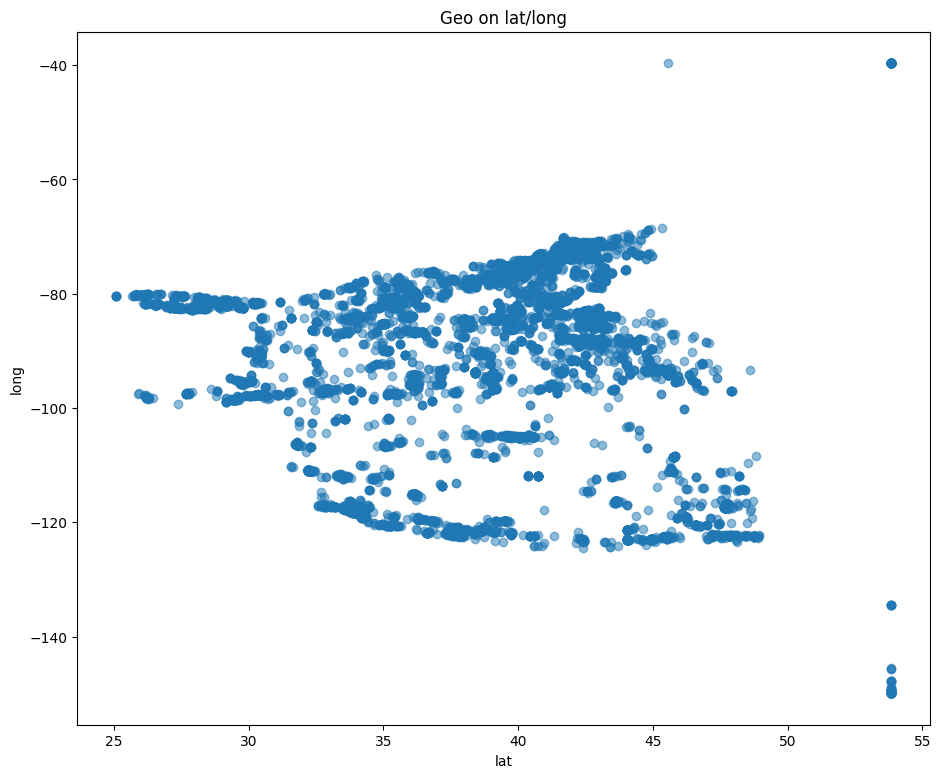

In [ ]:
plt.figure(figsize=(11, 9))
plt.scatter(df_clean.lat, df_clean.long, alpha=0.5)
plt.xlabel('lat')
plt.ylabel('long')
plt.title('Geo on lat/long')
plt.show()

На графике всё равно видны значения, выбивающиеся из общей картины. Сместим их поближе к реальной территории США

In [ ]:
lat_out = (df_clean['lat'] > 50)
long_out = ((df_clean['long'] < -129) | (df_clean['long'] > -60))

In [ ]:
df_clean.loc[lat_out, 'lat'] = 48

In [ ]:
df_clean.loc[long_out, 'long'] = -70

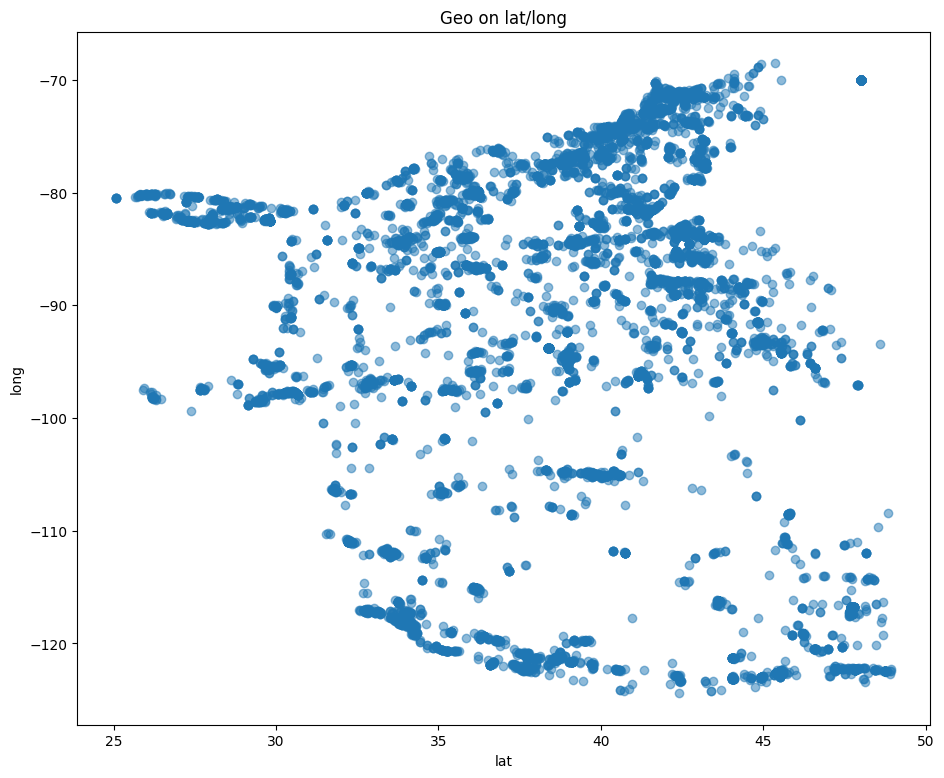

In [ ]:
plt.figure(figsize=(11, 9))
plt.scatter(df_clean.lat, df_clean.long, alpha=0.5)
plt.xlabel('lat')
plt.ylabel('long')
plt.title('Geo on lat/long')
plt.show()

## Exploratory Data Analisys

In [ ]:
df_clean.corr()

<ipython-input-73-798b28326b09>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_clean.corr()


,id,price,year,odometer,lat,long
id,1.000000,-0.031551,-0.077896,0.047828,-0.060957,-0.099582
price,-0.031551,1.000000,0.049568,-0.058096,0.002904,-0.002642
year,-0.077896,0.049568,1.000000,-0.288674,-0.028760,0.032472
odometer,0.047828,-0.058096,-0.288674,1.000000,0.018031,-0.018925
lat,-0.060957,0.002904,-0.028760,0.018031,1.000000,-0.070098
long,-0.099582,-0.002642,0.032472,-0.018925,-0.070098,1.000000


In [ ]:
pcs = df_clean.price_category.unique()
df_clean.groupby('price_category')['id'].count()

price_category
high      3495
low       3225
medium    3280
Name: id, dtype: int64

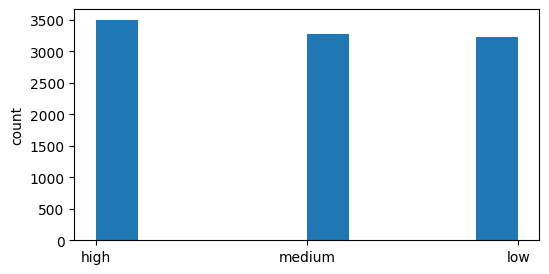

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(df_clean.price_category)
plt.ylabel('count')
plt.show()

В выборке примерно поровну машин разных ценовых категорий, что хорошо для обучения модели.

In [ ]:
fls = df_clean.fuel.unique()
df_clean.groupby('fuel')['price'].mean()

fuel
diesel      34221.004594
electric    27925.159091
gas         18795.404253
hybrid      14506.962963
other       30875.727397
Name: price, dtype: float64

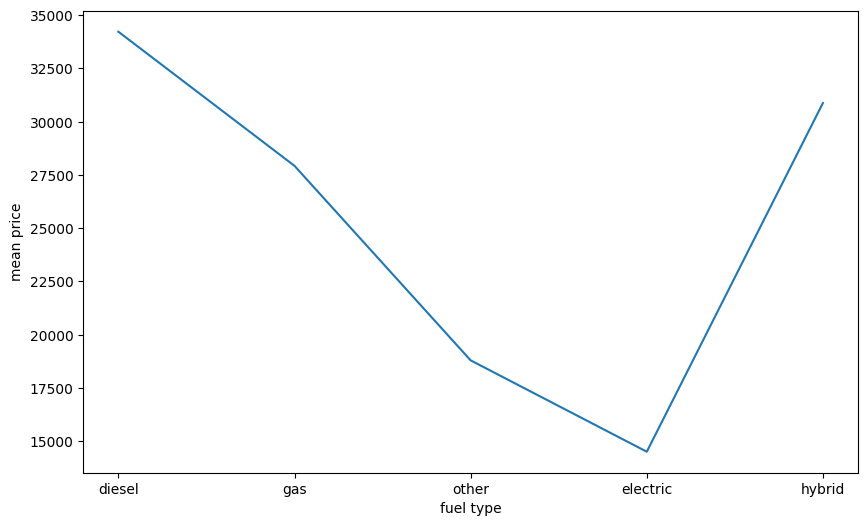

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fls, df_clean.groupby('fuel')['price'].mean())
plt.xlabel('fuel type')
plt.ylabel('mean price')
plt.show()

Видна зависимость между средней ценой и типом топлива.

In [ ]:
df_clean.groupby('title_status')['price'].mean()

title_status
clean         21010.424249
lien          24630.971429
missing       13040.500000
other         16555.198795
parts only     7350.000000
rebuilt       12826.795322
salvage        8477.804348
Name: price, dtype: float64

In [ ]:
cl = df_clean.title_status.unique()

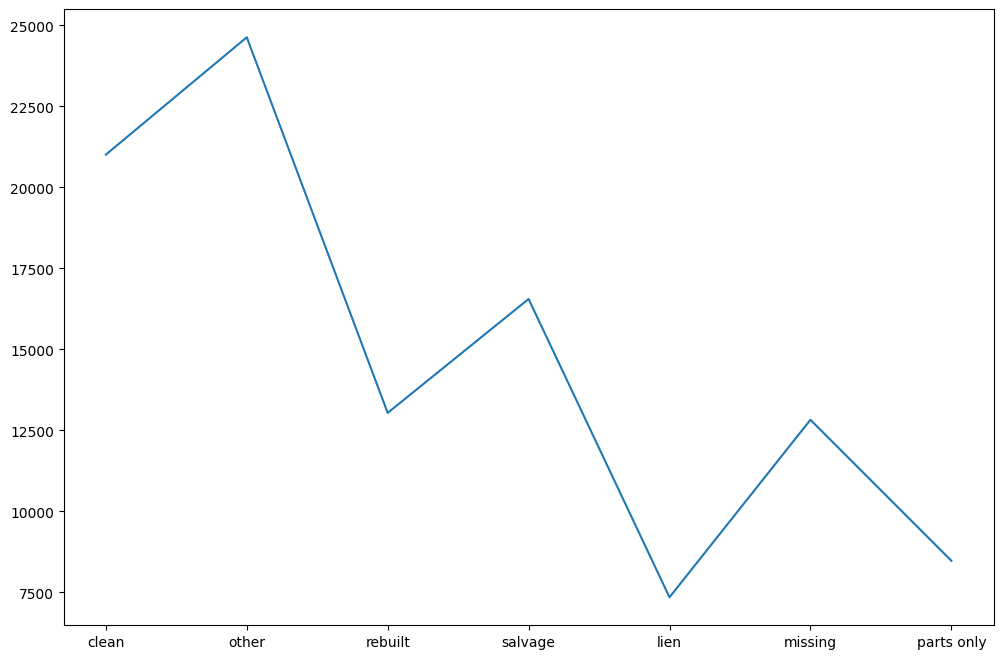

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(cl, df_clean.groupby('title_status')['price'].mean())
plt.show()

Заметна связь между средней ценой и статусом автомобиля. 

## Feature Engineering

### Feature Generating

In [ ]:
df_clean.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,title_status,transmission,image_url,description,state,lat,long,posting_date,price_category,date
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,clean,other,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,gas,60023,clean,automatic,https://images.craigslist.org/00x0x_26jl9F0cnL...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,clean,other,https://images.craigslist.org/00y0y_eeZjWeiSfb...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,clean,automatic,https://images.craigslist.org/00606_iGe5iXidib...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,clean,automatic,https://images.craigslist.org/00V0V_3pSOiPZ3Sd...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00


Создадим новый признак, содержащий длину описания в объявлении, и измерим его корреляцию с ценой.

In [ ]:
df_clean['desc_len'] = df_clean['description'].apply(lambda x: len(x))

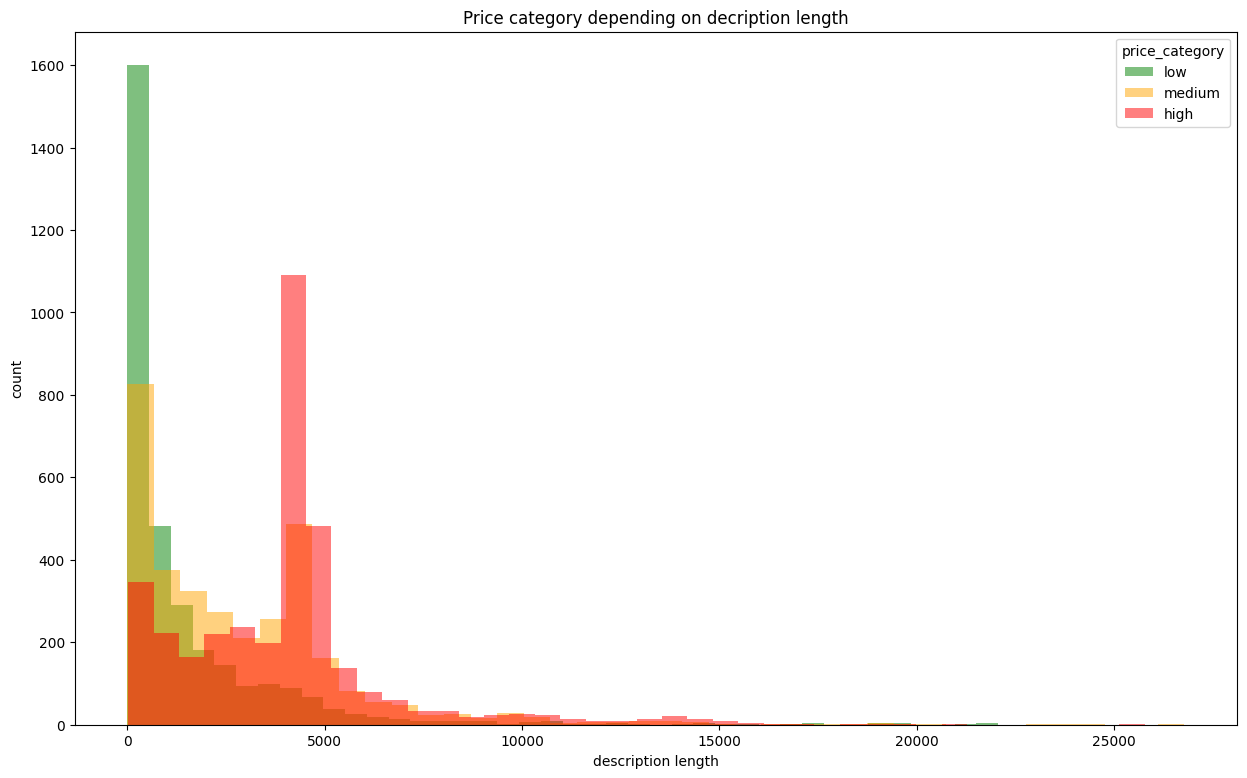

In [ ]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(15, 9))
for price_category in colors:
    color = colors[price_category]
    data = df_clean[df_clean['price_category'] == price_category]
    ax.hist(data['desc_len'], bins = 40, color=color, alpha=0.5)
plt.xlabel('description length')
plt.ylabel('count')
plt.title('Price category depending on decription length')
plt.legend(colors, title='price_category')
plt.show()

Видна связь длины объявления и цены авто. Признак создан не зря.

Гипотеза: количество пройденых миль за год влияет на стоимость авто, потому что отражает интенсивность использования. Сгенерируем признак "возраста" машины исходя из того, что сейчас 2023 год. Сгенерируем признак среднего пробега за год, поделив пробег на "позраст" авто.

In [ ]:
df_clean['year_own'] = 2023 - df_clean['year']

In [ ]:
df_clean['odom_year'] = df_clean['odometer'] / df_clean['year_own']

In [ ]:
df_clean['odom_year'].corr(df_clean['price'])

0.04182919028300242

Корреляция сравнима с корреляцием между ценой и общим пробегом.

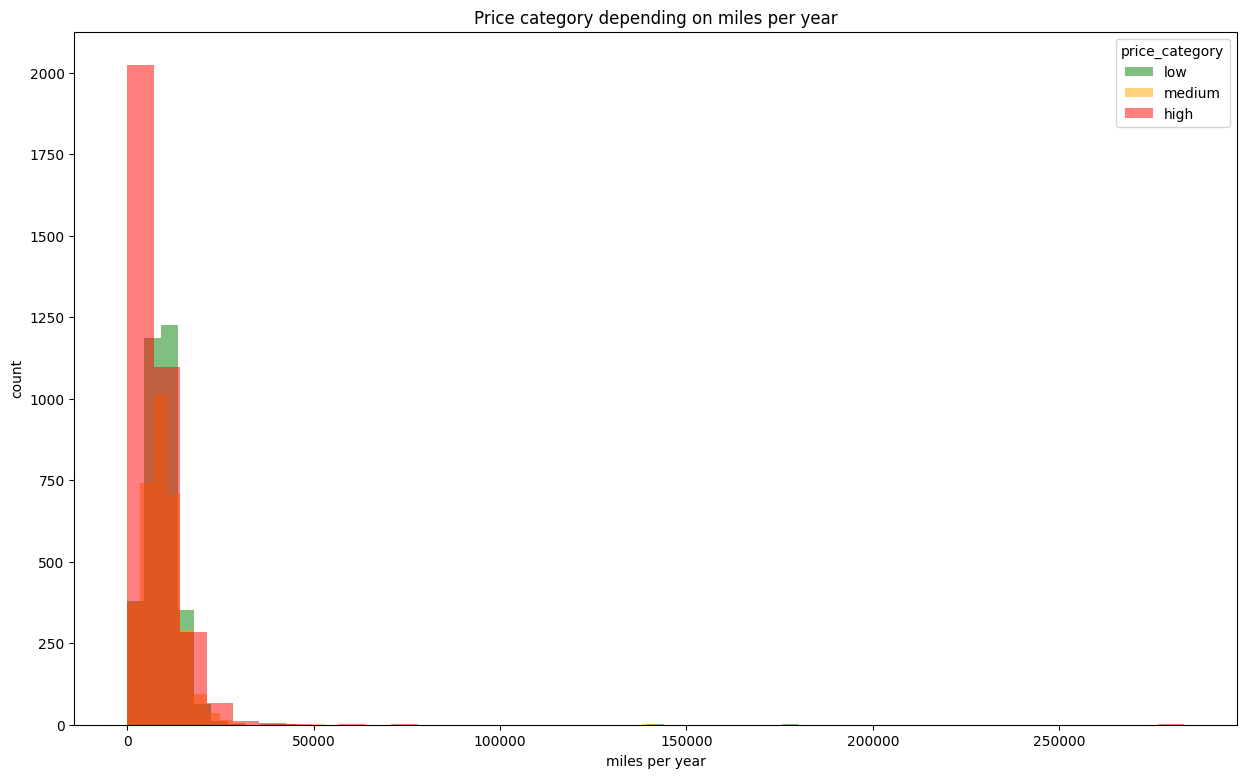

In [ ]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}
fig, ax = plt.subplots(figsize=(15, 9))
for price_category in colors:
    color = colors[price_category]
    data = df_clean[df_clean['price_category'] == price_category]
    ax.hist(data['odom_year'], bins = 40, color=color, alpha=0.5)
plt.xlabel('miles per year')
plt.ylabel('count')
plt.title('Price category depending on miles per year')
plt.legend(colors, title='price_category')
plt.show()

Видно, что интенсивность использования более дорогих машин меньше.

### Feature Catigorization

In [ ]:
df_clean.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,description,state,lat,long,posting_date,price_category,date,desc_len,year_own,odom_year
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,...,Carvana is the safer way to buy a car During t...,tn,35.060000,-85.250000,2021-04-17T12:30:50-0400,high,2021-04-17 16:30:50+00:00,4482,3.0,9147.333333
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,gas,60023,...,***Call Us for more information at: 201-635-14...,nj,40.821805,-74.061962,2021-05-03T15:40:21-0400,medium,2021-05-03 19:40:21+00:00,968,7.0,8574.714286
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,...,Carvana is the safer way to buy a car During t...,ca,33.779214,-84.411811,2021-04-28T03:52:20-0700,high,2021-04-28 10:52:20+00:00,4286,6.0,2341.333333
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,...,2013 Toyota RAV4 XLE 4dr SUV Offered by: R...,nc,35.715954,-78.655304,2021-04-17T10:08:57-0400,medium,2021-04-17 14:08:57+00:00,3241,10.0,11729.100000
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,...,2021 Nissan Altima Sv with Only 8 K Miles Titl...,ny,40.654800,-73.609700,2021-05-03T18:32:06-0400,medium,2021-05-03 22:32:06+00:00,538,2.0,4000.000000


In [ ]:
def categorization(feature):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(df_clean[[feature]])
    ohe_feature = ohe.transform(df_clean[[feature]])
    df_clean[ohe.get_feature_names_out()] = ohe_feature

In [ ]:
categorization('transmission')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
categorization('fuel')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Feature Scaling

In [ ]:
df_clean.head()

,id,url,region,region_url,price,year,manufacturer,model,fuel,odometer,...,year_own,odom_year,transmission_automatic,transmission_manual,transmission_other,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
0,7308295377,https://chattanooga.craigslist.org/ctd/d/chatt...,chattanooga,https://chattanooga.craigslist.org,54990,2020.0,ram,2500 crew cab big horn,diesel,27442,...,3.0,9147.333333,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,7316380095,https://newjersey.craigslist.org/ctd/d/carlsta...,north jersey,https://newjersey.craigslist.org,16942,2016.0,ford,explorer 4wd 4dr xlt,gas,60023,...,7.0,8574.714286,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7313733749,https://reno.craigslist.org/ctd/d/atlanta-2017...,reno / tahoe,https://reno.craigslist.org,35590,2017.0,volkswagen,golf r hatchback,gas,14048,...,6.0,2341.333333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,7308210929,https://fayetteville.craigslist.org/ctd/d/rale...,fayetteville,https://fayetteville.craigslist.org,14500,2013.0,toyota,rav4,gas,117291,...,10.0,11729.100000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7316474668,https://newyork.craigslist.org/lgi/cto/d/baldw...,new york city,https://newyork.craigslist.org,21800,2021.0,nissan,altima,gas,8000,...,2.0,4000.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
std = StandardScaler()

In [ ]:
def standartization(feature):
    std = StandardScaler()
    nfm = 'std_scaled_' + feature
    std.fit(df_clean[[feature]])
    std_scaled = std.transform(df_clean[[feature]])
    df_clean[nfm] = std_scaled

In [ ]:
standartization('year')

In [ ]:
standartization('year_own')

In [ ]:
standartization('price')

In [ ]:
standartization('odometer')

In [ ]:
standartization('odom_year')

In [ ]:
standartization('lat')

In [ ]:
standartization('long')

# Modeling

In [ ]:
df_clean.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'fuel', 'odometer', 'title_status', 'transmission',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date',
       'price_category', 'date', 'desc_len', 'year_own', 'odom_year',
       'transmission_automatic', 'transmission_manual', 'transmission_other',
       'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other',
       'std_scaled_year', 'std_scaled_year_own', 'std_scaled_price',
       'std_scaled_odometer', 'std_scaled_odom_year', 'std_scaled_lat',
       'std_scaled_long'],
      dtype='object')

In [ ]:
df_new = df_clean[['std_scaled_odometer', 'std_scaled_odom_year','transmission_automatic', 'transmission_manual',
       'transmission_other', 'fuel_diesel', 'fuel_electric', 'fuel_gas','std_scaled_year', 'std_scaled_year_own', 'price_category']]

In [ ]:
X = df_new.drop('price_category', axis = 1)

In [ ]:
Y = df_new['price_category']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

In [ ]:
for df in (x_train, x_test, y_train, y_test):
    print(df.shape)

(8000, 10)
(2000, 10)
(8000,)
(2000,)


In [ ]:
lgr = LogisticRegression(random_state=42, multi_class='multinomial', C=9)

In [ ]:
lgr.fit(x_train, y_train)

LogisticRegression(C=9, multi_class='multinomial', random_state=42)

In [ ]:
lgr_pred = lgr.predict(x_test)

In [ ]:
# Метрика точности модели LogisticRegression
accuracy_score(lgr_pred, y_test)

0.647

In [ ]:
mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(200, 50))

In [ ]:
mlp.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(200, 50))

In [ ]:
mlp_pred = mlp.predict(x_test)

In [ ]:
# Метрика точности модели MLPClassifier
accuracy_score(mlp_pred, y_test)

0.655

Точность MLP выше, чем у логистической регрессии.

# Evaluation

In [ ]:
cross_validate(lgr, X, Y, cv=5)

{'fit_time': array([0.13031721, 0.16629791, 0.18242502, 0.19235992, 0.1771903 ]),
 'score_time': array([0.00594687, 0.00519133, 0.00490856, 0.00410819, 0.00443864]),
 'test_score': array([0.646 , 0.647 , 0.6475, 0.642 , 0.657 ])}

In [ ]:
cross_validate(mlp, X, Y, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'fit_time': array([25.32131577, 20.16672611, 21.50639057, 12.15454245, 22.40899944]),
 'score_time': array([0.01524806, 0.01502013, 0.01486278, 0.01471066, 0.01443577]),
 'test_score': array([0.6605, 0.6445, 0.655 , 0.648 , 0.6575])}

Переобучение при кросс-валидации не выявлено.

# Results

In [ ]:
mlp.fit(X, Y)

MLPClassifier(activation='logistic', hidden_layer_sizes=(200, 50))

In [ ]:
filename = 'model.pickle'

In [ ]:
with open(filename, 'wb') as file:
  pickle.dump(mlp, file)